# Probability Dsitributions and Random Variables

To embark on an exciting journey into the realm of probabilistic thinking and programming, it's essential to establish a solid foundation. This foundation entails gaining a comprehensive understanding of probability distributions, mastering fundamental probability principles, and acquiring the skills to manipulate probabilities within code.

Probability distributions and random variables serve as tools for describing and performing calculations related to random events, specifically those whose outcomes are uncertain. An illustrative instance of such an uncertain event would be the act of flipping a coin or rolling a dice. In the former case, the potential outcomes are heads or tails.

*In the context of epidemiological modelling, we will encounter data of different type and origin. It is crucial to grasp the suitability of different probability distributions for modeling specific types of data.*

Since the PPL we will be using for this course is **Numpyro**, also in this section we will use the implementations of distribution from this library `import numpyro.distributions as dist`

In [ ]:
# uncomment this line on Colab
# !pip install numpyro

In [29]:
import jax
import jax.numpy as jnp

# dsitributions
import numpyro.distributions as dist

import matplotlib.pyplot as plt

# Since we are using jax, we will need a random key:
rng = jax.random.PRNGKey(42)

## Discrete Distributions

### The Bernoulli distribution

A Bernoulli distribution is used to describe random events with two possible outcomes e.g. when we have a random variable $X$ that takes on one of the two values $x \in \{0, 1\}$ with probabilities $1-p$ and $p, 0 \le p \le 1$ respectively:

\begin{align*}
p(X = 1) &= p, \\
p(X = 0) &= 1 - p.
\end{align*}

Here $p$ is the probability of the 'positive' outcome. For example, in the case of a *fair* coin toss, $p = 0.5$ so that both outcomes have a 50\% chance of occurring. As we will see shortly, most distributions have multiple parameters.

#### Probability mass function
A *discrete* probability distribution can be uniquely defined by its *probability mass function (PMF)*.

```{margin}
The term 'mass' is used to underline that the support of the distribution is discrete, and each possible values carries a certain `mass` (probability).
For continuous distributions, the analogous is *probability density function (PDF)*, we will see those later.
```
For the Bernoulli distribution, we write the PMF as

\begin{align}
p(X = x) = \text{Bernoulli}(X\mid p) &= \begin{cases}
p\, & \text{if } x = 1 \\
1 - p\, & \text{if } x = 0
\end{cases} \\
&= p^x(1-p)^{1-x}.
\end{align}

**Exercise:** convince yourself that the two definitions of the Bernoulli distribution shown above are equivalent.

Now let's construct a Bernoulli distribution in code so that we can play around with it and get some intuition.

**Note:** In this practical, we are going to use `numpyro` to construct our distributions. However, there are several other `jax` packages that work similarly (e.g., `distrax`) as well as several options for `tensorflow` (e.g., `tensorflow_probability`) and `pytorch` (e.g., `torch.distribution`). Don't worry too much about the specifics of how `numpyro` works, e.g., the names of the distributions and their arguments. Instead try to understand what the code is doing.

We construct the distribution with a certain value of the parameter `p`:

In [10]:
p = jnp.array(0.5)
bernoulli = dist.Bernoulli(probs=p)

Now that we have constructed the distribution we can get a *sample* from it:

```{margin}
We can think of a sample as a realisation of the random variable. 
```

In [15]:
sample = bernoulli.sample(key=rng)
print(sample)

1


And we can evaluate the probability of observing a sample.

**Note:** the distribution objects in `numpyro` (and indeed most other libraries for probability distributions) return *log*-probabilities rather than raw probabilities. This means that we need to take the exponent if we want to know the probability.

In [16]:
log_prob = bernoulli.log_prob(sample)
print(f"log p(X = {sample}) = {log_prob}")
print(f"p(X = {sample}) = {jnp.exp(log_prob)}")

log p(X = 1) = -0.6931471824645996
p(X = 1) = 0.5


As expected, we get a probability of 0.5.

#### Multiple samples

We can also easily get multiple samples:

```{margin}
Multiple samples are different realisations of the *same* random variable.
```

In [22]:
n = 7
samples = bernoulli.sample(key=rng, sample_shape=(n,))
print(samples)

[0 0 1 1 0 1 1]


What if we wanted to evaluate the probability of observing all of our samples?

The `bernoulli` object we created earlier treats each sample individually and returns the probabilities of observing each sample on its own:

In [26]:
individual_sample_probs = jnp.exp(bernoulli.log_prob(samples))
print(individual_sample_probs)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5]


But, we can use one of the laws of probability to compute the probability of observing all of the samples together:
$$
p(X_1=x_1, X_2=x_2, \dots, X_N=x_n) = \prod_{n=1}^N p(X_n=x_n).
$$
This is called the *product rule of probability*, and it says that for *independent* random variables, the joint probability (i.e., the probability of observing them all together) is equal to the product of the individual probabilities.

Now, let's calculate the joint probability of our samples.

```{margin}
Working with log-probabilities is preferable due to numerical stability, computational efficiency, and ease of handling multiplicative operations.
```

In [27]:
joint_prob = jnp.prod(individual_sample_probs)
print(joint_prob)

0.0078125


In [30]:
def Bernouilli_vis(rng, p, n):

    # define distribution
    bernoulli_ = dist.Bernoulli(probs=p)

    # collect samples
    samples = bernoulli_.sample(key=rng, sample_shape=(n,))

    # how many ones
    num_ones = (samples == 1.).sum()

    # how many zeros
    num_zeros = (samples == 0.).sum()

    # plot
    fig = plt.figure(dpi=100, figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar([0, 1], [num_zeros/n, num_ones/n])
    ax.set_xticks([0, 1])
    ax.set_xlabel('x')
    ax.set_ylabel('p(X=x)')
    plt.show()



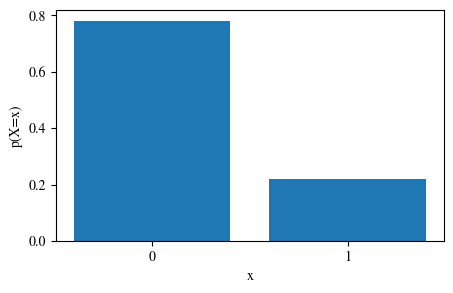

In [31]:
p = 0.2
n = 100
Bernouilli_vis(rng, p, n)

**Exercise:**  plot a panel of histograms where you vary probability $p$ horizontally and numher of samples $n$ vertically. 

### The Binomial distribution

### The Categorical distribution

### The Ordered distribution

## Continuous Distributions

### Beta distribution

### Gamma distribution

### Normal distribution

### Multivariate Normal distribution